# Interpolation vs Extrapolation

This code will investigate the difference in performance of an ANN when the same problem is an interpolation problem, with data all around the requested examples, and when it's an extrapolation problem, and the requested examples are close but beyond the limits of the region of the training data. We will be using the emissivity spectra of SiO2 spheres using Mie formalism.

## Imports and Datasets

In [3]:
# Libraries needed to import for this example

import numpy as np                    # Basic numerical python library
import matplotlib.pyplot as plt       # Plotting library for python

import tensorflow as tf               # Google library for Deep Learning
import keras as kr                    # High-level API for Tensorflow

In [4]:
# Mie dataset to import: 100 emission spectra from 10 nm radius to 300 microns radius

labels_Mie_raw = np.genfromtxt('Datasets/Mie_labels.dat')
data_Mie_raw = np.genfromtxt('Datasets/Mie_data.dat')

In [5]:
# Evaluation metric: Mean relative absolute error per point

def mean_relative_abs_error_pointwise(net, inputs, target):
    
    Npoints = target.shape[1]
    Nexamples = target.shape[0]
    
    error = np.zeros([1,1])
    
    for i in range(Nexamples):
                
        fake = np.reshape(net(np.reshape(inputs[i],(1,1))),(Npoints,))
        
        faked = 10**(fake*data_std+data_mean)
        realed = 10**(target[i,:]*data_std+data_mean)
        
        for j in range(Npoints):
            
            error = error + np.abs((faked[j]-realed[j])/realed[j])
    
    return error/(Npoints*Nexamples)*100

## Baseline Network

We will create a network analyzing the problem properly to use as a baseline for comparison of results.

Per-point mean relative error of training set: [[0.87015595]]
Per-point mean relative error of validation set: [[1.38195232]]


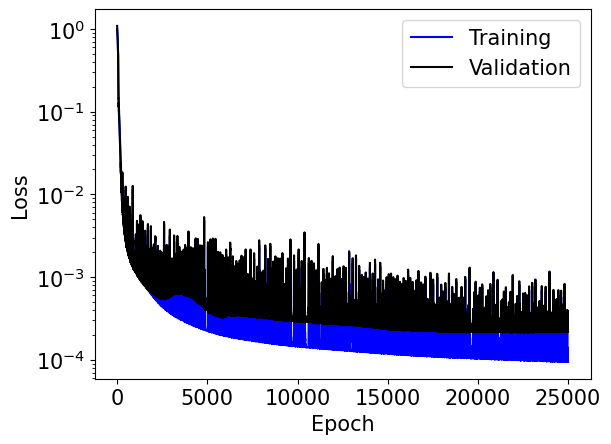

In [7]:
# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering

random_index = np.linspace(0,data_Mie_raw.shape[0]-1,data_Mie_raw.shape[0]) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros(labels_Mie_raw.shape)
labels_Mie_rand = np.zeros(labels_Mie_raw.shape)

data_Mie = np.zeros(data_Mie_raw.shape)
data_Mie_rand = np.zeros(data_Mie_raw.shape)

for i in range(data_Mie_raw.shape[0]):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

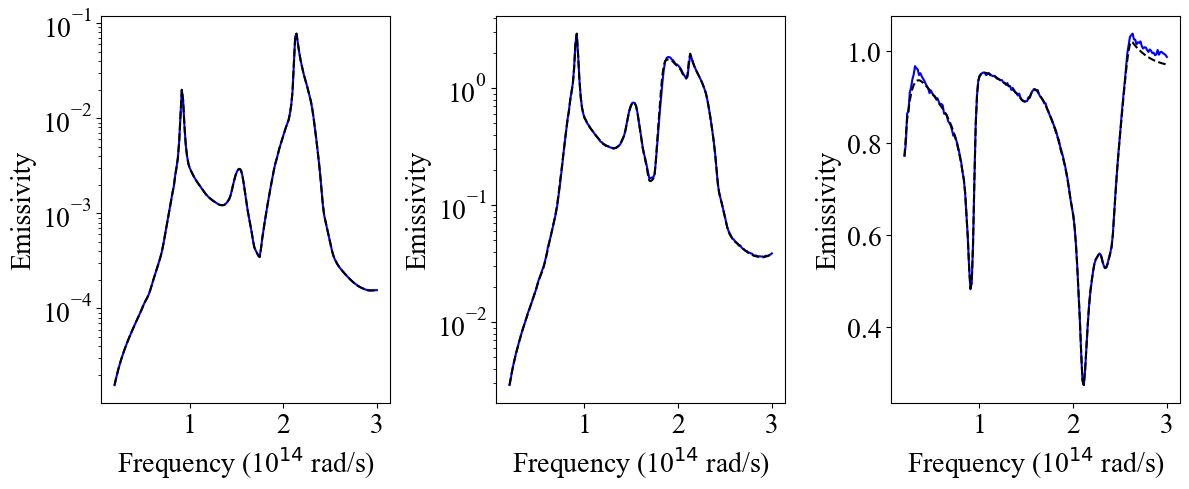

In [8]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[0])
input_2 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2)])
input_3 = np.log10(labels_Mie_raw[-1])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[0,:]
true2 = data_Mie_raw[int(data_Mie_raw.shape[0]/2),:]
true3 = data_Mie_raw[-1,:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].semilogy(x,trial1,color='blue')
axs[0].semilogy(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].semilogy(x,trial2,color='blue')
axs[1].semilogy(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].plot(x,trial3,color='blue')
axs[2].plot(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_baseline.png', format='png', dpi=600)
plt.show()

## Interpolation

In this section we will study the interpolation capabilities of the Network

Per-point mean relative error of training set: [[1.95180201]]
Per-point mean relative error of validation set: [[2.52132093]]


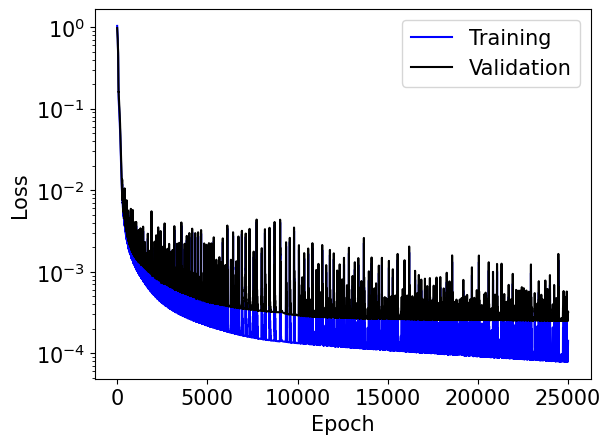

In [23]:
# Trial 1: train with even indices, validate with odd indices

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering

random_index = np.linspace(0,data_Mie_raw.shape[0]-1,data_Mie_raw.shape[0]) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros(labels_Mie_raw.shape)
labels_Mie_rand = np.zeros(labels_Mie_raw.shape)

data_Mie = np.zeros(data_Mie_raw.shape)
data_Mie_rand = np.zeros(data_Mie_raw.shape)

for i in range(data_Mie_raw.shape[0]):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,99,100).astype(int)[0::2]
val_index = np.linspace(0,99,100).astype(int)[1::2]

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

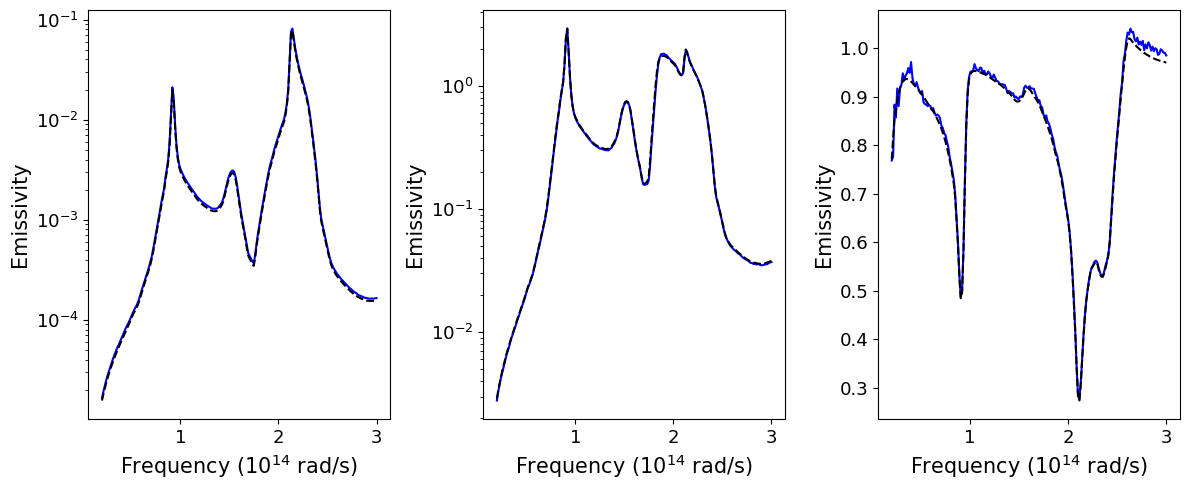

In [24]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[0])
input_2 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2)])
input_3 = np.log10(labels_Mie_raw[-1])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[0,:]
true2 = data_Mie_raw[int(data_Mie_raw.shape[0]/2),:]
true3 = data_Mie_raw[-1,:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].semilogy(x,trial1,color='blue')
axs[0].semilogy(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].semilogy(x,trial2,color='blue')
axs[1].semilogy(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].plot(x,trial3,color='blue')
axs[2].plot(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_odds.png', format='png', dpi=600)
plt.show()

Per-point mean relative error of training set: [[0.66782663]]
Per-point mean relative error of validation set: [[0.92240384]]
Per-point mean relative error of interpolation set: [[23.07933953]]


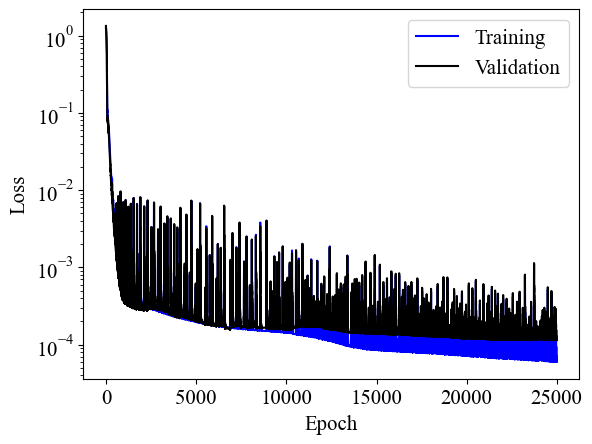

In [9]:
# Trial 2: leave a central gap of L (even) indices, train with usual split

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

L = int(30) # Size of the central gap we will make, L/2 on each side

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering (excluding the test part)

test_indices = np.linspace(data_Mie_raw.shape[0]/2-L/2,data_Mie_raw.shape[0]/2+L/2-1,L).astype(int)

random_index1 = np.linspace(0,data_Mie_raw.shape[0]/2-L/2-1,int(data_Mie_raw.shape[0]/2-L/2)).astype(int) # Create list of all indices
random_index2 = np.linspace(data_Mie_raw.shape[0]/2+L/2,data_Mie_raw.shape[0]-1,int(data_Mie_raw.shape[0]/2-L/2)).astype(int) # Create list of all indices
random_index = np.concatenate((random_index1,random_index2)) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_rand = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_test = np.zeros((test_indices.shape[0],))

data_Mie = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_rand = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_test = np.zeros((test_indices.shape[0],data_Mie_raw.shape[1]))

for i in range(data_Mie_raw.shape[0]-L):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std
    
for i in range(test_indices.shape[0]):
    
    test_ind = int(test_indices[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie_test[i] = np.log10(labels_Mie_raw[test_ind])
    
    # Normalize the outputs using the log
    
    data_Mie_test[i,:] = (np.log10(data_Mie_raw[test_ind,:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))
print('Per-point mean relative error of interpolation set:', mean_relative_abs_error_pointwise(net, labels_Mie_test, data_Mie_test))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

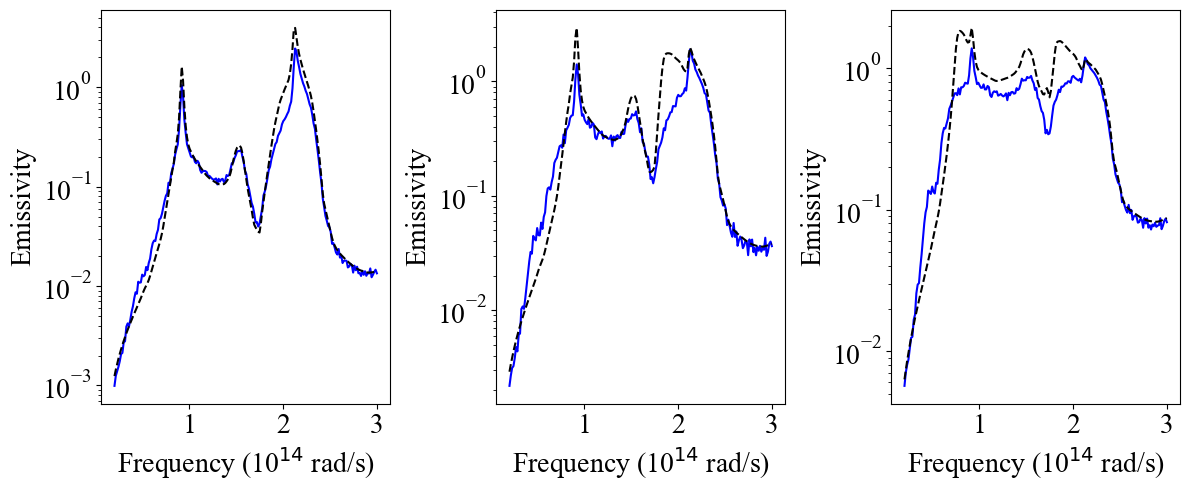

In [10]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2-L/4)])
input_2 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2)])
input_3 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2+L/4)])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[int(data_Mie_raw.shape[0]/2-L/4),:]
true2 = data_Mie_raw[int(data_Mie_raw.shape[0]/2),:]
true3 = data_Mie_raw[int(data_Mie_raw.shape[0]/2+L/4),:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].semilogy(x,trial1,color='blue')
axs[0].semilogy(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].semilogy(x,trial2,color='blue')
axs[1].semilogy(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].semilogy(x,trial3,color='blue')
axs[2].semilogy(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_central_gap.png', format='png', dpi=600)
plt.show()

Per-point mean relative error of training set: [[1.50378502]]
Per-point mean relative error of validation set: [[1.92629418]]
Per-point mean relative error of interpolation set: [[11.52428096]]


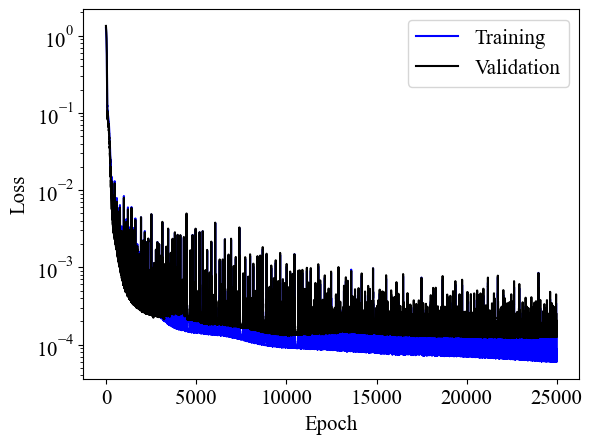

In [11]:
# Trial 3: leave a central gap of L (even) indices, train with usual split, add central one 

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

L = int(30) # Size of the central gap we will make, L/2 on each side

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering (excluding the test part)

test_indices1 = np.linspace(int(data_Mie_raw.shape[0]/2-L/2),int(data_Mie_raw.shape[0]/2-1),int(L/2)).astype(int)
test_indices2 = np.linspace(int(data_Mie_raw.shape[0]/2+1),int(data_Mie_raw.shape[0]/2+L/2-1),int(L/2-1)).astype(int)
test_indices = np.concatenate((test_indices1,test_indices2)) # Create list of all indices

random_index1 = np.linspace(0,int(data_Mie_raw.shape[0]/2-L/2-1),int(data_Mie_raw.shape[0]/2-L/2)) # Create list of all indices
random_index2 = np.linspace(int(data_Mie_raw.shape[0]/2+L/2),int(data_Mie_raw.shape[0]-1),int(data_Mie_raw.shape[0]/2-L/2)) # Create list of all indices
random_index = np.concatenate((random_index1,random_index2)) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_rand = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_test = np.zeros((test_indices.shape[0],))

data_Mie = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_rand = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_test = np.zeros((test_indices.shape[0],data_Mie_raw.shape[1]))

for i in range(data_Mie_raw.shape[0]-L):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std
    
for i in range(test_indices.shape[0]):
    
    test_ind = int(test_indices[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie_test[i] = np.log10(labels_Mie_raw[test_ind])
    
    # Normalize the outputs using the log
    
    data_Mie_test[i,:] = (np.log10(data_Mie_raw[test_ind,:])-data_mean)/data_std
    
labels_extra_example = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2)])
data_extra_example = (np.log10(data_Mie_raw[int(data_Mie_raw.shape[0]/2),:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

labels_Mie_rand_train = np.concatenate((labels_Mie_rand_train,np.reshape(labels_extra_example,(1,))))
data_Mie_rand_train = np.concatenate((data_Mie_rand_train,np.reshape(data_extra_example,(1,200))))

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))
print('Per-point mean relative error of interpolation set:', mean_relative_abs_error_pointwise(net, labels_Mie_test, data_Mie_test))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

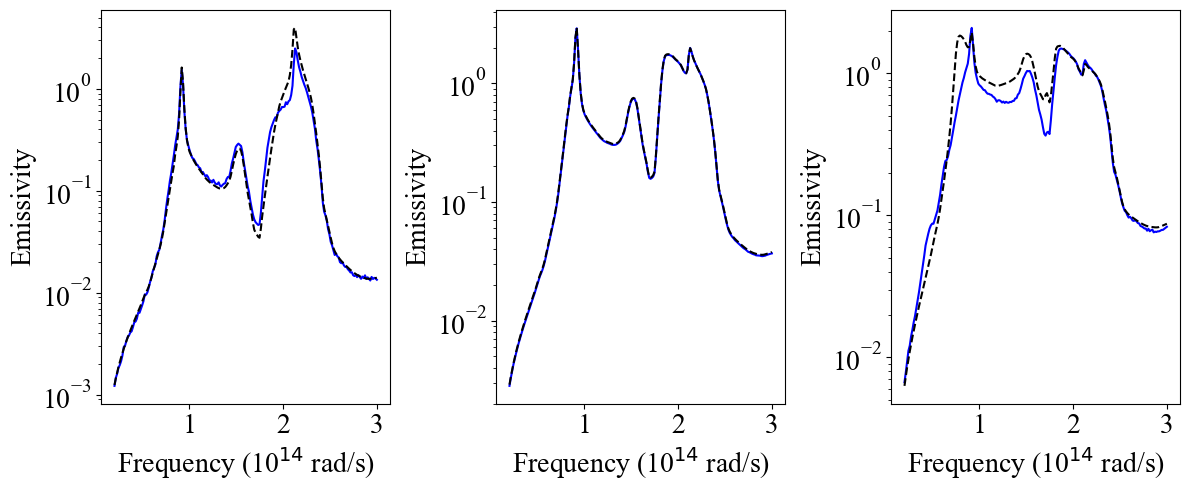

In [12]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2-L/4)])
input_2 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2)])
input_3 = np.log10(labels_Mie_raw[int(data_Mie_raw.shape[0]/2+L/4)])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[int(data_Mie_raw.shape[0]/2-L/4),:]
true2 = data_Mie_raw[int(data_Mie_raw.shape[0]/2),:]
true3 = data_Mie_raw[int(data_Mie_raw.shape[0]/2+L/4),:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].semilogy(x,trial1,color='blue')
axs[0].semilogy(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].semilogy(x,trial2,color='blue')
axs[1].semilogy(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].semilogy(x,trial3,color='blue')
axs[2].semilogy(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_central_gap1.png', format='png', dpi=600)
plt.show()

## Extrapolation

In this section we will study the extrapolation capabilities of the network, or lack thereof

Per-point mean relative error of training set: [[1.31007483]]
Per-point mean relative error of validation set: [[1.77151222]]
Per-point mean relative error of interpolation set: [[309.23735887]]


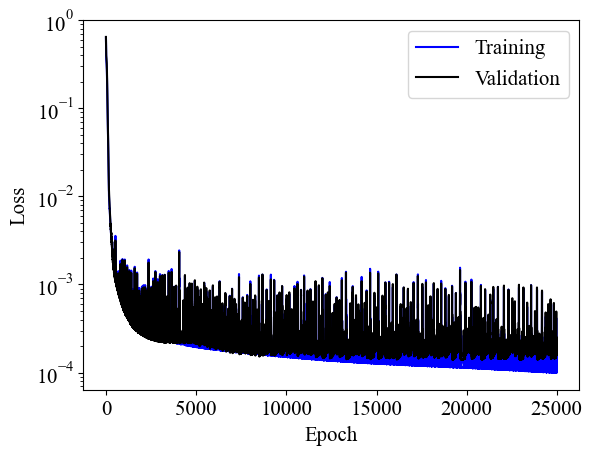

In [13]:
# Trial 1: remove the L smallest spheres

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

L = int(20) # Ammount of the smallest examples we delete

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering (excluding the test part)

test_indices = np.linspace(0,L-1,L).astype(int)

random_index = np.linspace(L,labels_Mie_raw.shape[0]-1,labels_Mie_raw.shape[0]-L).astype(int) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_rand = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_test = np.zeros((test_indices.shape[0],))

data_Mie = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_rand = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_test = np.zeros((test_indices.shape[0],data_Mie_raw.shape[1]))

for i in range(data_Mie_raw.shape[0]-L):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std
    
for i in range(test_indices.shape[0]):
    
    test_ind = int(test_indices[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie_test[i] = np.log10(labels_Mie_raw[test_ind])
    
    # Normalize the outputs using the log
    
    data_Mie_test[i,:] = (np.log10(data_Mie_raw[test_ind,:])-data_mean)/data_std
    
# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))
print('Per-point mean relative error of interpolation set:', mean_relative_abs_error_pointwise(net, labels_Mie_test, data_Mie_test))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

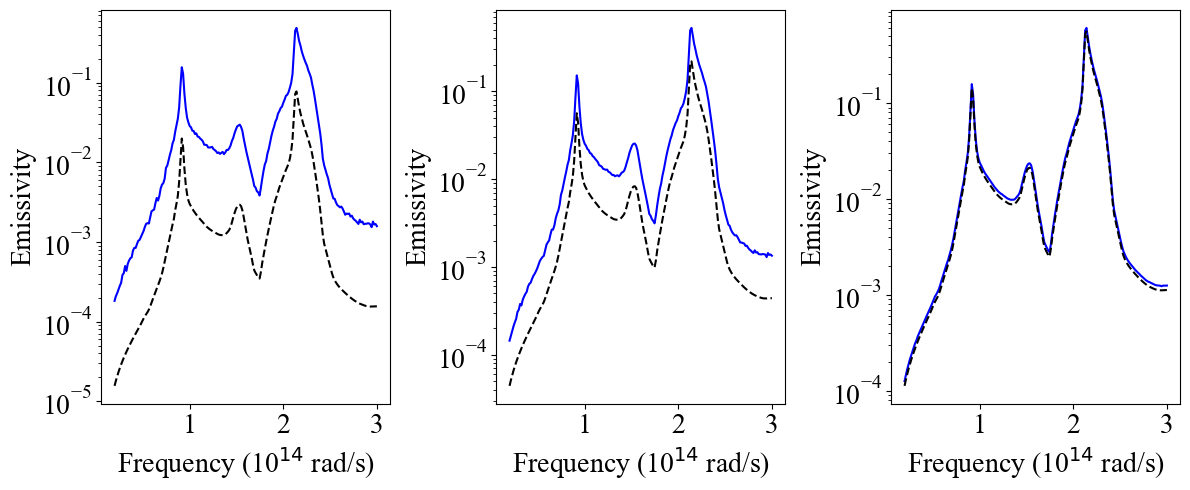

In [14]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[0])
input_2 = np.log10(labels_Mie_raw[int(L/2)])
input_3 = np.log10(labels_Mie_raw[L-1])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[0,:]
true2 = data_Mie_raw[int(L/2),:]
true3 = data_Mie_raw[L-1,:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].semilogy(x,trial1,color='blue')
axs[0].semilogy(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].semilogy(x,trial2,color='blue')
axs[1].semilogy(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].semilogy(x,trial3,color='blue')
axs[2].semilogy(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_small_gone.png', format='png', dpi=600)
plt.show()

Per-point mean relative error of training set: [[1.57848687]]
Per-point mean relative error of validation set: [[1.99460997]]
Per-point mean relative error of interpolation set: [[17.95425501]]


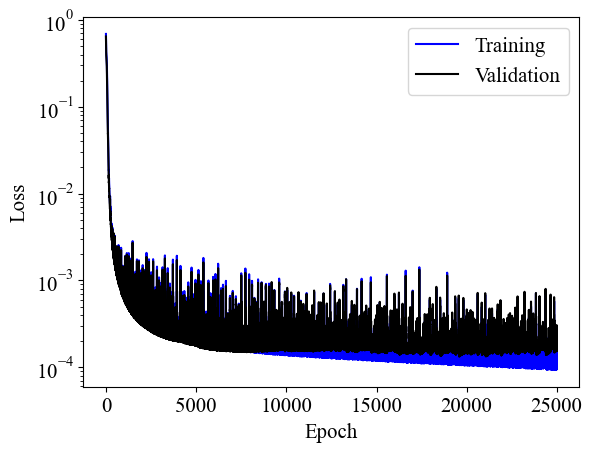

In [15]:
# Trial 2: remove the L smallest spheres, add smallest to training set

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

L = int(20) # Ammount of the smallest examples we delete

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering (excluding the test part)

test_indices = np.linspace(1,L-1,L).astype(int)

random_index = np.linspace(L,labels_Mie_raw.shape[0]-1,labels_Mie_raw.shape[0]-L).astype(int) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_rand = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_test = np.zeros((test_indices.shape[0],))

data_Mie = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_rand = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_test = np.zeros((test_indices.shape[0],data_Mie_raw.shape[1]))

for i in range(data_Mie_raw.shape[0]-L):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std

for i in range(test_indices.shape[0]):
    
    test_ind = int(test_indices[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie_test[i] = np.log10(labels_Mie_raw[test_ind])
    
    # Normalize the outputs using the log
    
    data_Mie_test[i,:] = (np.log10(data_Mie_raw[test_ind,:])-data_mean)/data_std
    
labels_extra_example = np.log10(labels_Mie_raw[0])
data_extra_example = (np.log10(data_Mie_raw[0,:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

labels_Mie_rand_train = np.concatenate((labels_Mie_rand_train,np.reshape(labels_extra_example,(1,))))
data_Mie_rand_train = np.concatenate((data_Mie_rand_train,np.reshape(data_extra_example,(1,200))))

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))
print('Per-point mean relative error of interpolation set:', mean_relative_abs_error_pointwise(net, labels_Mie_test, data_Mie_test))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

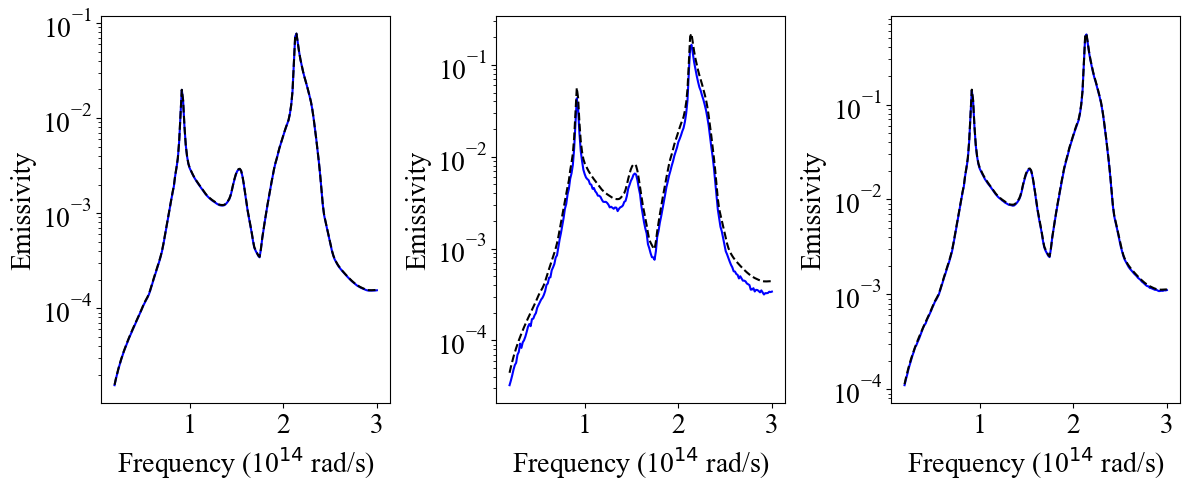

In [16]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[0])
input_2 = np.log10(labels_Mie_raw[int(L/2)])
input_3 = np.log10(labels_Mie_raw[L-1])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[0,:]
true2 = data_Mie_raw[int(L/2),:]
true3 = data_Mie_raw[L-1,:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].semilogy(x,trial1,color='blue')
axs[0].semilogy(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].semilogy(x,trial2,color='blue')
axs[1].semilogy(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].semilogy(x,trial3,color='blue')
axs[2].semilogy(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_small_gone1.png', format='png', dpi=600)
plt.show()

Per-point mean relative error of training set: [[1.19466715]]
Per-point mean relative error of validation set: [[1.55801669]]
Per-point mean relative error of interpolation set: [[30.80619049]]


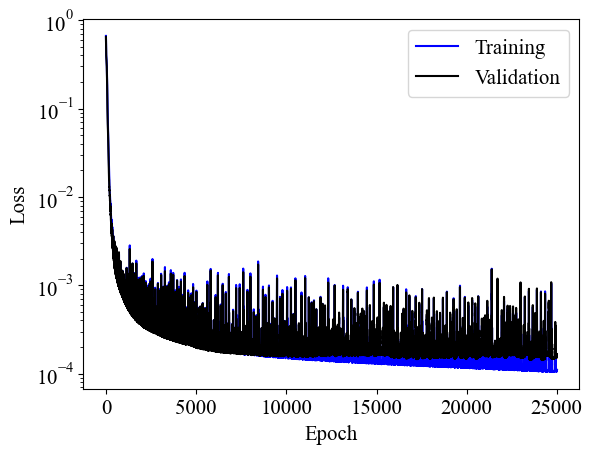

In [17]:
# Trial 3: remove the L smallest spheres, add middle one in removed group to training set

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

L = int(20) # Ammount of the smallest examples we delete

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering (excluding the test part)

test_indices1 = np.linspace(0,int(L/2-1),int(L/2)).astype(int)
test_indices2 = np.linspace(int(L/2+1),L,int(L/2-1)).astype(int)
test_indices = np.concatenate((test_indices1,test_indices2)) # Create list of all indices

random_index = np.linspace(L,labels_Mie_raw.shape[0]-1,labels_Mie_raw.shape[0]-L).astype(int) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_rand = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_test = np.zeros((test_indices.shape[0],))

data_Mie = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_rand = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_test = np.zeros((test_indices.shape[0],data_Mie_raw.shape[1]))

for i in range(data_Mie_raw.shape[0]-L):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std

for i in range(test_indices.shape[0]):
    
    test_ind = int(test_indices[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie_test[i] = np.log10(labels_Mie_raw[test_ind])
    
    # Normalize the outputs using the log
    
    data_Mie_test[i,:] = (np.log10(data_Mie_raw[test_ind,:])-data_mean)/data_std
    
labels_extra_example = np.log10(labels_Mie_raw[int(L/2)])
data_extra_example = (np.log10(data_Mie_raw[int(L/2),:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

labels_Mie_rand_train = np.concatenate((labels_Mie_rand_train,np.reshape(labels_extra_example,(1,))))
data_Mie_rand_train = np.concatenate((data_Mie_rand_train,np.reshape(data_extra_example,(1,200))))

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))
print('Per-point mean relative error of interpolation set:', mean_relative_abs_error_pointwise(net, labels_Mie_test, data_Mie_test))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

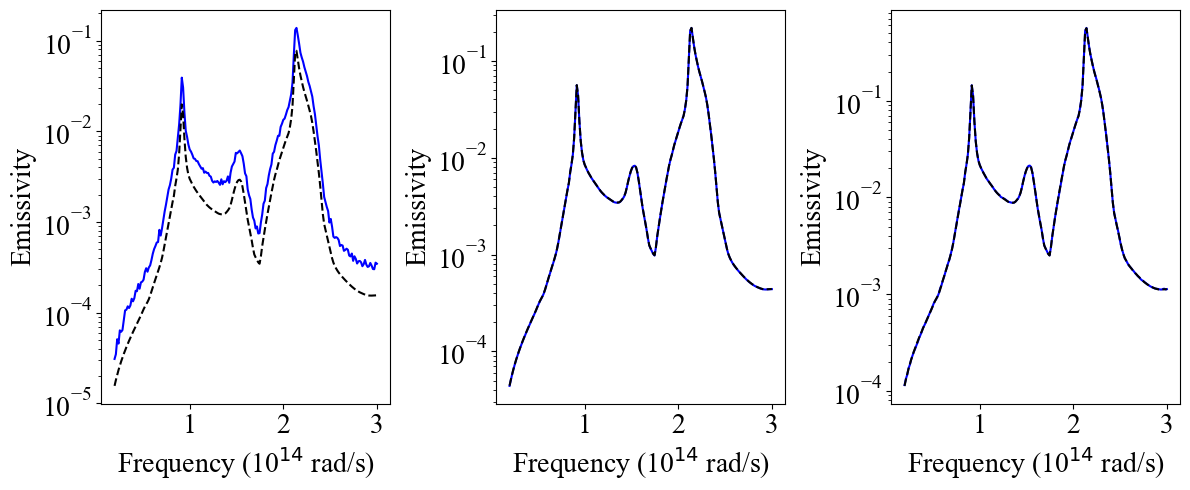

In [18]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[0])
input_2 = np.log10(labels_Mie_raw[int(L/2)])
input_3 = np.log10(labels_Mie_raw[L-1])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[0,:]
true2 = data_Mie_raw[int(L/2),:]
true3 = data_Mie_raw[L-1,:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].semilogy(x,trial1,color='blue')
axs[0].semilogy(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].semilogy(x,trial2,color='blue')
axs[1].semilogy(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].semilogy(x,trial3,color='blue')
axs[2].semilogy(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_small_gone2.png', format='png', dpi=600)
plt.show()

Per-point mean relative error of training set: [[0.87531693]]
Per-point mean relative error of validation set: [[1.94945497]]
Per-point mean relative error of interpolation set: [[29.74169385]]


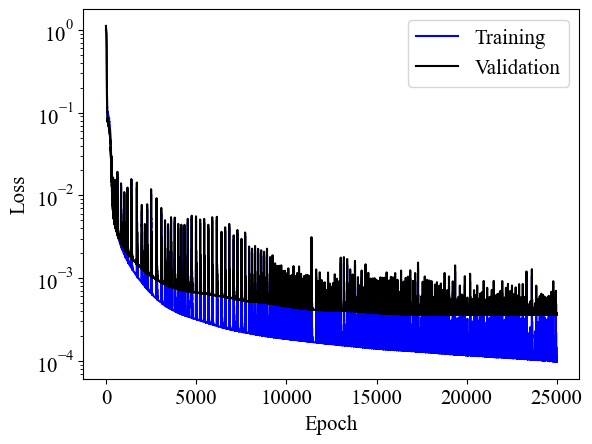

In [19]:
# Trial 4: remove the L biggest spheres

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

L = int(20) # Ammount of the smallest examples we delete

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering (excluding the test part)

test_indices = np.linspace(labels_Mie_raw.shape[0]-L,labels_Mie_raw.shape[0]-1,L).astype(int)

random_index = np.linspace(0,labels_Mie_raw.shape[0]-L-1,labels_Mie_raw.shape[0]-L).astype(int) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_rand = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_test = np.zeros((test_indices.shape[0],))

data_Mie = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_rand = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_test = np.zeros((test_indices.shape[0],data_Mie_raw.shape[1]))

for i in range(data_Mie_raw.shape[0]-L):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std
    
for i in range(test_indices.shape[0]):
    
    test_ind = int(test_indices[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie_test[i] = np.log10(labels_Mie_raw[test_ind])
    
    # Normalize the outputs using the log
    
    data_Mie_test[i,:] = (np.log10(data_Mie_raw[test_ind,:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))
print('Per-point mean relative error of interpolation set:', mean_relative_abs_error_pointwise(net, labels_Mie_test, data_Mie_test))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

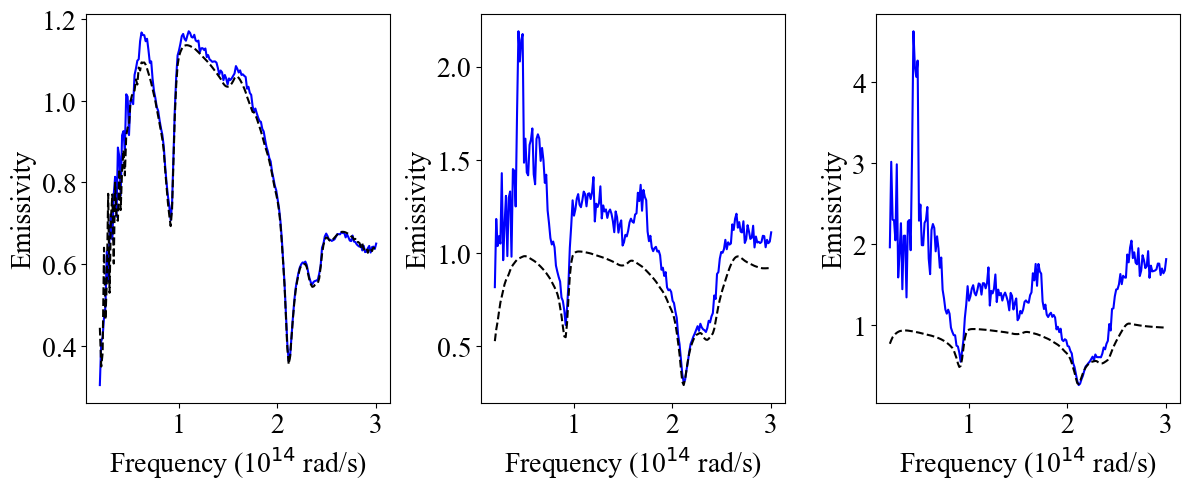

In [20]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[data_Mie_raw.shape[0]-L])
input_2 = np.log10(labels_Mie_raw[data_Mie_raw.shape[0]-int(L/2)])
input_3 = np.log10(labels_Mie_raw[data_Mie_raw.shape[0]-1])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[data_Mie_raw.shape[0]-L,:]
true2 = data_Mie_raw[data_Mie_raw.shape[0]-int(L/2),:]
true3 = data_Mie_raw[data_Mie_raw.shape[0]-1,:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].plot(x,trial1,color='blue')
axs[0].plot(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].plot(x,trial2,color='blue')
axs[1].plot(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].plot(x,trial3,color='blue')
axs[2].plot(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_big_gone.png', format='png', dpi=600)
plt.show()

Per-point mean relative error of training set: [[2.0345826]]
Per-point mean relative error of validation set: [[2.75551526]]
Per-point mean relative error of interpolation set: [[4.36739712]]


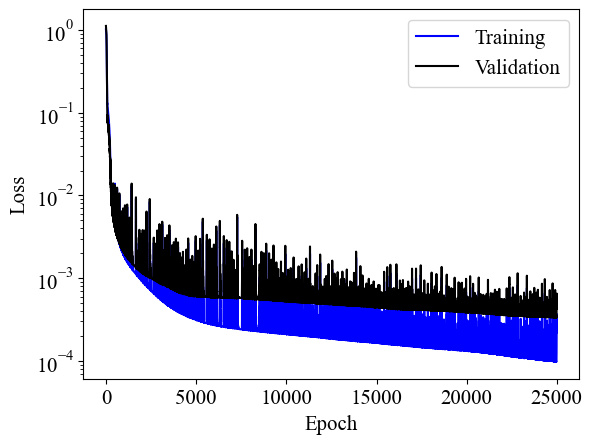

In [21]:
# Trial 5: remove the L biggest spheres, add the biggest one

# We will create a network that goes from 1 input (radius) to 200 outputs (frequency values for spectrum)

np.random.seed(42) # Fix the random seed for numpy
kr.utils.set_random_seed(42) # Fix the random seed for Keras

L = int(20) # Ammount of the smallest examples we delete

# Step 1: obtain and normalize datasets

# We will use the log of the input and output values

# Normalization

input_mean = np.mean(np.log10(labels_Mie_raw), axis = 0) # Mean of the input values
input_std = np.std(np.log10(labels_Mie_raw), axis = 0) # Standard deviation of the input values

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

# Create the random ordering (excluding the test part)

test_indices = np.linspace(labels_Mie_raw.shape[0]-L,labels_Mie_raw.shape[0]-2,L-1).astype(int)

random_index = np.linspace(0,labels_Mie_raw.shape[0]-L-1,labels_Mie_raw.shape[0]-L).astype(int) # Create list of all indices
np.random.shuffle(random_index) # Randomly order them

# Populate the sets

labels_Mie = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_rand = np.zeros((labels_Mie_raw.shape[0]-L,))
labels_Mie_test = np.zeros((test_indices.shape[0],))

data_Mie = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_rand = np.zeros((data_Mie_raw.shape[0]-L,data_Mie_raw.shape[1]))
data_Mie_test = np.zeros((test_indices.shape[0],data_Mie_raw.shape[1]))

for i in range(data_Mie_raw.shape[0]-L):
    
    rand_ind = int(random_index[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie[i] = np.log10(labels_Mie_raw[i])
    labels_Mie_rand[i] = np.log10(labels_Mie_raw[rand_ind])
    
    # Normalize the outputs using the log
    
    data_Mie[i,:] = (np.log10(data_Mie_raw[i,:])-data_mean)/data_std
    data_Mie_rand[i,:] = (np.log10(data_Mie_raw[rand_ind,:])-data_mean)/data_std

for i in range(test_indices.shape[0]):
    
    test_ind = int(test_indices[i])
    
    # We won't normalize the inputs, just take the log
    
    labels_Mie_test[i] = np.log10(labels_Mie_raw[test_ind])
    
    # Normalize the outputs using the log
    
    data_Mie_test[i,:] = (np.log10(data_Mie_raw[test_ind,:])-data_mean)/data_std
    
labels_extra_example = np.log10(labels_Mie_raw[-1])
data_extra_example = (np.log10(data_Mie_raw[-1,:])-data_mean)/data_std

# Step 2: create the network with optimized hyperparameters

input_label = kr.Input((1,))
netl = kr.layers.Dense(50, activation = 'relu')(input_label)
netl = kr.layers.Dense(100, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(200, activation = 'relu')(netl)
netl = kr.layers.Dense(data_Mie_raw.shape[1])(netl) # Connected the layers one after the other

net = kr.Model(input_label,netl) # Create the full network

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Choose optimizer

net.compile(loss='mean_squared_error', optimizer=opt) # Compile the network

# Step 3: train the network

batch_size = 100
n_epochs = 25000
val_percentage = 0.2

train_index = np.linspace(0,int((1-val_percentage)*data_Mie.shape[0]-1),int((1-val_percentage)*data_Mie.shape[0])).astype(int)
val_index = np.linspace(int((1-val_percentage)*data_Mie.shape[0]),data_Mie.shape[0]-1,int(val_percentage*data_Mie.shape[0])).astype(int)

labels_Mie_rand_train = labels_Mie_rand[train_index]
labels_Mie_rand_val = labels_Mie_rand[val_index]

data_Mie_rand_train = data_Mie_rand[train_index]
data_Mie_rand_val = data_Mie_rand[val_index]

labels_Mie_rand_train = np.concatenate((labels_Mie_rand_train,np.reshape(labels_extra_example,(1,))))
data_Mie_rand_train = np.concatenate((data_Mie_rand_train,np.reshape(data_extra_example,(1,200))))

net2 = net.fit(labels_Mie_rand_train,data_Mie_rand_train,batch_size=batch_size, validation_data=(labels_Mie_rand_val,data_Mie_rand_val), epochs=n_epochs, verbose = 0)
loss = net2.history['loss'] #recording of loss
val_loss = net2.history['val_loss'] #recording of val_loss

# Step 4: plot and write the results

print('Per-point mean relative error of training set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_train, data_Mie_rand_train))
print('Per-point mean relative error of validation set:', mean_relative_abs_error_pointwise(net, labels_Mie_rand_val, data_Mie_rand_val))
print('Per-point mean relative error of interpolation set:', mean_relative_abs_error_pointwise(net, labels_Mie_test, data_Mie_test))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(loss,color='blue')
axs.plot(val_loss,color='black')
axs.set_ylabel('Loss', fontsize = 20)
axs.set_yscale('log')
axs.set_xlabel('Epoch', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['Training', 'Validation'], loc='upper right', fontsize = 20)
plt.show()

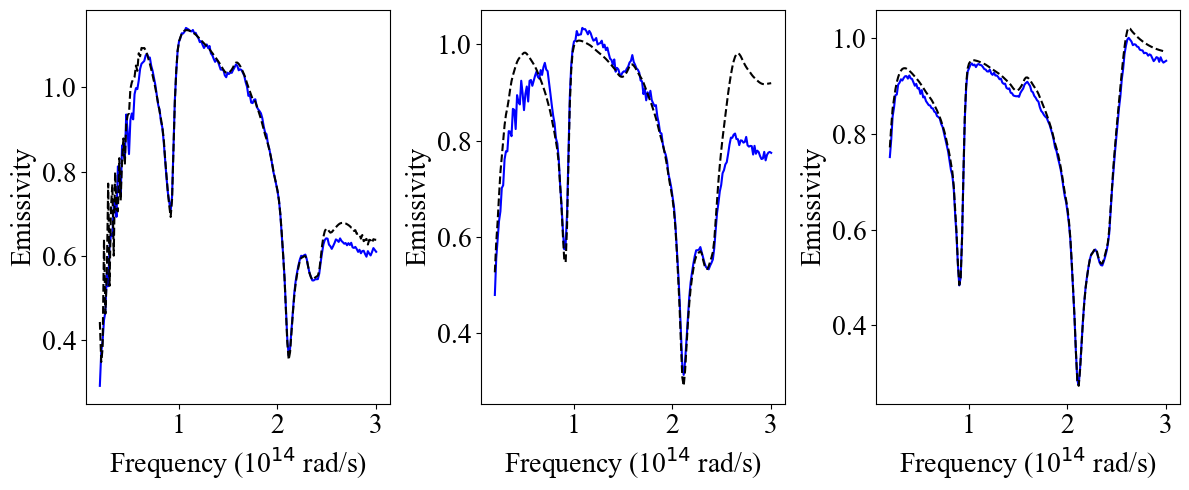

In [22]:
# Plot some samples

x = np.linspace(0.2,3,data_Mie_raw.shape[1])

data_mean = np.mean(np.log10(data_Mie_raw), axis = 0) # Mean of the output values
data_std = np.std(np.log10(data_Mie_raw), axis = 0) # Standard deviation of the output values

input_1 = np.log10(labels_Mie_raw[data_Mie_raw.shape[0]-L])
input_2 = np.log10(labels_Mie_raw[data_Mie_raw.shape[0]-int(L/2)])
input_3 = np.log10(labels_Mie_raw[data_Mie_raw.shape[0]-1])

trial1 = 10**(np.reshape(net(np.reshape(input_1,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial2 = 10**(np.reshape(net(np.reshape(input_2,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)
trial3 = 10**(np.reshape(net(np.reshape(input_3,(1,1))),(data_Mie_raw.shape[1],))*data_std+data_mean)

true1 = data_Mie_raw[data_Mie_raw.shape[0]-L,:]
true2 = data_Mie_raw[data_Mie_raw.shape[0]-int(L/2),:]
true3 = data_Mie_raw[data_Mie_raw.shape[0]-1,:]

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,3,figsize=(12,5))
axs[0].plot(x,trial1,color='blue')
axs[0].plot(x,true1,'--k')
axs[0].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[0].set_ylabel('Emissivity', fontsize = 20)
axs[0].tick_params(axis='both', labelsize = 20)
axs[1].plot(x,trial2,color='blue')
axs[1].plot(x,true2,'--k')
axs[1].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[1].set_ylabel('Emissivity', fontsize = 20)
axs[1].tick_params(axis='both', labelsize = 20)
axs[2].plot(x,trial3,color='blue')
axs[2].plot(x,true3,'--k')
axs[2].set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs[2].set_ylabel('Emissivity', fontsize = 20)
axs[2].tick_params(axis='both', labelsize = 20)
plt.tight_layout()
fig.savefig('Interp_extrap_big_gone1.png', format='png', dpi=600)
plt.show()